<a href="https://colab.research.google.com/github/VishwathRam/GAN_PyTorch/blob/main/GAN_synthetic_image_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import glob as glob
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchvision import datasets, models, transforms
import time
import os
import copy
from collections import OrderedDict

from torch.autograd import variable

import shutil

In [ ]:
img_dt='/content/drive/MyDrive/Projects/'

def transformation(pth):
  data_transforms= transforms.Compose(
    [
        transforms.Resize((32,32)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])
  dt=datasets.ImageFolder(pth,transform=data_transforms)

  return dt

In [ ]:
train_data=transformation(img_dt)

In [ ]:
def data_load(dt,batch_size,num_workers):
  x=torch.utils.data.DataLoader(dt, batch_size=batch_size, num_workers=num_workers, shuffle=True)

  return x

In [ ]:
train_loader=data_load(train_data, batch_size=64, num_workers=2)

In [ ]:
import torch.nn.functional as F

#building the conv layer

def conv_layer(cin, cout,kernel_size,stride=2,padding=1,batch_norm=True):
  layers=[]
  conv=nn.Conv2d(cin, cout,
                 kernel_size,stride, padding, bias=False)
  #appen layers

  layers.append(conv)

  if batch_norm:
    layers.append(nn.BatchNorm2d(cout))
  
  return nn.Sequential(*layers)


class Discriminator(nn.Module):

  def __init__(self, conv_dim=32):#32
    super(Discriminator,self).__init__()
    self.conv_dim=conv_dim
    self.conv1=conv_layer(3,conv_dim,4,batch_norm=False)
    self.conv2=conv_layer(conv_dim, conv_dim*2,4, batch_norm=True)
    self.conv3=conv_layer(conv_dim*2,conv_dim*4,4)
    self.fc=nn.Linear(conv_dim*4*4*4,1)

  def forward(self,x):
    output=F.leaky_relu(self.conv1(x),0.2)
    output=F.leaky_relu(self.conv2(output),0.2)
    output=F.leaky_relu(self.conv3(output),0.2)
    output=output.view(-1,self.conv_dim*4*4*4)
    output=self.fc(output)

    return output

In [ ]:
'''Building the deconv func'''

def deconv_layer(cin, cout,kernel_size,stride=2,padding=1,batch_norm=True):
  layers=[]
  transpose_conv=nn.ConvTranspose2d(cin, cout,
                 kernel_size,stride, padding, bias=False)
  layers.append(transpose_conv)
  if batch_norm:
    layers.append(nn.BatchNorm2d(cout))
  return nn.Sequential(*layers)

In [ ]:
'''Building the generator'''

class Generator(nn.Module):
  def __init__(self,z_in,conv_dim=32):#32
    super(Generator, self).__init__()
    self.conv_dim=conv_dim

    self.fc=nn.Linear(z_in,conv_dim*4*4*4)

    self.d_conv1=deconv_layer(conv_dim*4,conv_dim*2,4)
    self.d_conv2=deconv_layer(conv_dim*2, conv_dim,4)
    self.d_conv3=deconv_layer(conv_dim,3,4,batch_norm=True)   

  def forward(self, x):
    output=self.fc(x)
    output=output.view(-1, self.conv_dim*4,4,4) 

    output=F.relu(self.d_conv1(output))
    output=F.relu(self.d_conv2(output))

    output=self.d_conv3(output)
    output=F.tanh(output)

    return output

In [ ]:
'''Instantianting the whole network, setting hyperparams'''

conv_dim=32
z_size=100

discrim_net=Discriminator(conv_dim)
gen_net=Generator(z_in=z_size, conv_dim=conv_dim)

In [ ]:
#printing discriminator net
print(discrim_net)

Discriminator(
  (conv1): Sequential(
    (0): Conv2d(3, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
  )
  (conv2): Sequential(
    (0): Conv2d(32, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (conv3): Sequential(
    (0): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc): Linear(in_features=2048, out_features=1, bias=True)
)


In [ ]:
#printing generator net
print(gen_net)

Generator(
  (fc): Linear(in_features=100, out_features=2048, bias=True)
  (d_conv1): Sequential(
    (0): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (d_conv2): Sequential(
    (0): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (d_conv3): Sequential(
    (0): ConvTranspose2d(32, 3, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
)


In [ ]:
'''Defining the loss, generator loss and discriminator loss'''
if torch.cuda.is_available():
  gen_net.cuda()
  discrim_net.cuda()
  print("Training on GPU")

else:
  print(" Training on CPU")

def loss_real(D_out,smooth=False):
  batch_size=D_out.size(0)
  #label smoothing
  if smooth:
    #smoothing and real labels=0.9
    labels=torch.ones(batch_size)*0.9
  else:
    #real labels
    labels=torch.ones(batch_size)
  if torch.cuda.is_available():
    labels=labels.cuda()
  criterion=nn.BCEWithLogitsLoss()
  loss=criterion(D_out.squeeze(),labels)
  return loss


def loss_fake(D_out):
  batch_size=D_out.size(0)

  labels=torch.zeros(batch_size)
  labels=torch.zeros(batch_size)

  if torch.cuda.is_available():
    labels= labels.cuda()
  criterion=nn.BCEWithLogitsLoss()
  loss=criterion(D_out.squeeze(), labels)

  return loss

Training on GPU


In [ ]:
#setting the optimmisers for both generator and discriminator

lr=0.0002
beta1=0.5
beta2=0.999
discrim_optim=optim.Adam(discrim_net.parameters(),lr,[beta1,beta2])
gen_optim=optim.Adam(gen_net.parameters(), lr, [beta1,beta2])

In [ ]:
# helper scale function
def scale(x, feature_range=(-1, 1)):
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [ ]:
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [ ]:
def dice(y_true, y_pred):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f * y_pred_f)
    smooth = 0.0001
    return (2. * intersection + smooth) / (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)

In [ ]:
num_epochs=50
#loss and generated, fake samples

samples=[]
losses=[]
print_every=300

sample_size=16
fixed_z=np.random.uniform(-1,1,size=(sample_size,z_size))
fixed_z=torch.from_numpy(fixed_z).float()

for epoch in range(num_epochs):
  for batch_i, (real_img, _) in enumerate(train_loader):
    batch_size=real_img.size(0)

    real_img=scale(real_img)
    discrim_optim.zero_grad()
    rimg=real_img
    if torch.cuda.is_available():
      real_img=real_img.cuda()
    D_real=discrim_net(real_img)
    d_loss_real=loss_real(D_real)
    z=np.random.uniform(-1,1,size=(batch_size,z_size))
    z=torch.from_numpy(z).float()

    if torch.cuda.is_available():
      z=z.cuda()
    fake_img=gen_net(z)
    D_fake=discrim_net(fake_img)
    D_fake_loss=loss_fake(D_fake)

    # adding loss and perfom backprop

    d_loss=d_loss_real +D_fake_loss
    d_loss.backward()
    discrim_optim.step()


    #---------------------------------
    # Training the Generator
    #--------------------------------

    gen_optim.zero_grad()
    z=np.random.uniform(-1,1,size=(batch_size, z_size))
    z=torch.from_numpy(z).float()

    if torch.cuda.is_available():
      z=z.cuda()

    fake_img=gen_net(z)

    #calculate the discriminator loss on fake images using flipped labels

    D_fake=discrim_net(fake_img)
    g_loss=loss_real(D_fake) 

    g_loss.backward()
    gen_optim.step()

    #calculating the dice score
    rimg=rimg.numpy()
    rimg=NormalizeData(rimg)
    fake_img=fake_img.data.cpu().numpy()
    fake_img=NormalizeData(fake_img)

    if batch_i % print_every==0:
      losses.append((d_loss.item(),g_loss.item()))
      print(
          'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f}'.format(
                    epoch+1, num_epochs, d_loss.item(), g_loss.item())
          #'Epoch [{:5d}/{:5d}] | d_loss: {:6.4f} | g_loss: {:6.4f} | dice: {:6.4f}'.format(
                    #epoch+1, num_epochs, d_loss.item(), g_loss.item(), dice_score)
      )

    
  
  '''Generating and saving sample images after each epoch'''

  gen_net.eval() #generating sample images

  if torch.cuda.is_available():
    fixed_z=fixed_z.cuda()
  samples_z=gen_net(fixed_z)
  samples.append(samples_z)
  gen_net.train()

Epoch [    1/   50] | d_loss: 0.6044 | g_loss: 1.6195
Epoch [    2/   50] | d_loss: 0.2799 | g_loss: 2.2500
Epoch [    3/   50] | d_loss: 0.1667 | g_loss: 3.1860
Epoch [    4/   50] | d_loss: 0.0974 | g_loss: 3.5484
Epoch [    5/   50] | d_loss: 0.0599 | g_loss: 3.9495
Epoch [    6/   50] | d_loss: 0.0441 | g_loss: 4.2118
Epoch [    7/   50] | d_loss: 0.0255 | g_loss: 4.8604
Epoch [    8/   50] | d_loss: 0.1938 | g_loss: 4.0926
Epoch [    9/   50] | d_loss: 0.0461 | g_loss: 4.1575
Epoch [   10/   50] | d_loss: 0.0348 | g_loss: 4.8257
Epoch [   11/   50] | d_loss: 0.0278 | g_loss: 5.4308
Epoch [   12/   50] | d_loss: 0.0272 | g_loss: 5.2679
Epoch [   13/   50] | d_loss: 0.1026 | g_loss: 5.8450
Epoch [   14/   50] | d_loss: 5.6124 | g_loss: 3.1723
Epoch [   15/   50] | d_loss: 0.0470 | g_loss: 4.0251
Epoch [   16/   50] | d_loss: 0.8396 | g_loss: 5.9887
Epoch [   17/   50] | d_loss: 0.1925 | g_loss: 4.2472
Epoch [   18/   50] | d_loss: 0.0577 | g_loss: 4.0900
Epoch [   19/   50] | d_loss

In [ ]:
#saving generated sample images as pickle file
import pickle as pkl
with open('train_samples.pkl','wb') as f:
  pkl.dump(samples,f)

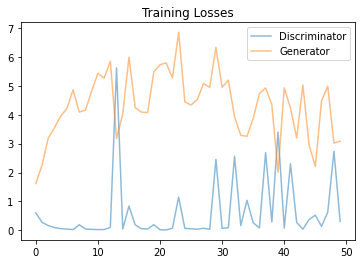

In [ ]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [ ]:
#viewing samples of generated images

def sample_view(epoch, samples):
  fig, axes = plt.subplots(figsize=(16,4), nrows=2, ncols=8, sharey=True, sharex=True)
  for ax, img in zip(axes.flatten(), samples[epoch]):
    img = img.detach().cpu().numpy()
    img = np.transpose(img, (1, 2, 0))
    img = ((img +1)*255 / (2)).astype(np.uint8) # rescale to pixel range (0-255)isic 
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    im = ax.imshow(img.reshape((32,32,3)))#32 32 3

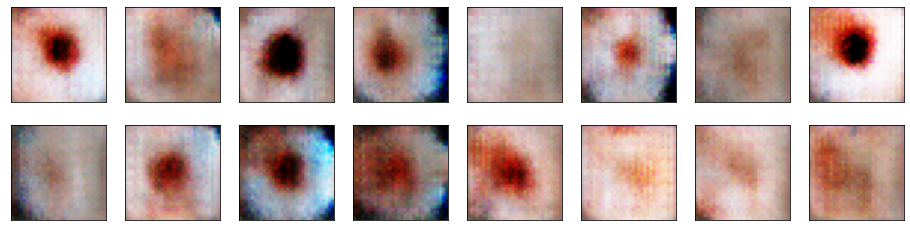

In [ ]:

_=sample_view(-1,samples)